In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from glob import glob
import pydicom
import tensorflow as tf
import tqdm as tqdm
"""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

## having an idea of the input Images ##

In [2]:
imageFolderPath = "../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10062"
imageFiles = sorted(glob(os.path.join(imageFolderPath, "*.dcm")))
image_path = imageFiles[0]
image = pydicom.dcmread(image_path)
print(image.pixel_array.shape)

(512, 512)


## Creating the list of filenames and labels ##

In [3]:
# creating a list of  filenames and labels
trainImagesPath = "../input/rsna-2022-cervical-spine-fracture-detection/train_images"
trainDfPath = "../input/rsna-2022-cervical-spine-fracture-detection/train.csv"
trainDf = pd.read_csv(trainDfPath)
trainImagesPathList = []
labels = []

for i in tqdm.tqdm(range(len(trainDf))):
    folderName = trainDf["StudyInstanceUID"].iloc[i]
    imageFolderPath = os.path.join(trainImagesPath, folderName)
    
    for file in glob(os.path.join(imageFolderPath, "*.dcm")):
        # taking the imageName
        trainImagesPathList.append(file)
        # creating the labels
        label = np.array([trainDf["C1"].iloc[i],trainDf["C2"].iloc[i], trainDf["C3"].iloc[i], trainDf["C4"].iloc[i], trainDf["C5"].iloc[i], 
                         trainDf["C6"].iloc[i], trainDf["C7"].iloc[i], trainDf["patient_overall"].iloc[i]])
        labels.append(label)
        
print(len(trainImagesPathList), " : ", len(labels))

100%|██████████| 2019/2019 [04:24<00:00,  7.63it/s]

711601  :  711601


In [4]:
print(trainImagesPathList[0].split("/")[-2])
print(labels[0])
example_file = pydicom.dcmread(trainImagesPathList[0])
print(example_file)

1.2.826.0.1.3680043.6200
[1 1 0 0 0 0 0 1]
Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.6200.1.240
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.6200.1.240
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '185002.042922'
(0010, 0010) Patient's Name                      PN: '6200'
(0010, 0020) Patient ID                          LO: '6200'
(0018, 0050) Slice 

# Creating the Dataset #

In [5]:
print(labels[0])

[1 1 0 0 0 0 0 1]


In [6]:
import tensorflow_io as tfio

def parse_function(filename, label):
    print("Inside parse function")
    #print("Filename : ", filename.as_numpy_iterator())
    
    image_bytes = tf.io.read_file(filename)

    image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)
    
    return image, label
    """
    image_string = pydicom.dcmread(str(filename))
    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=1)

    #This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)

    resized_image = tf.image.resize(image, [256, 256])
    print("Resized Image : ", resized_image.shape)
    return resized_image, label
    """
def train_preprocess(image, label):
    return image, label


def creatingDataset(filenames, labels, batch_size = 4):
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    print(list(dataset.as_numpy_iterator())[0][0])
    print(type(list(dataset.as_numpy_iterator())[0][0]))
    #dataset = dataset.shuffle(len(filenames))
    dataset = dataset.map(parse_function)
    #dataset = dataset.map(train_preprocess, num_parallel_calls=4)
    #dataset = dataset.batch(batch_size)
    #dataset = dataset.prefetch(1)
    
    return dataset

dataset = creatingDataset(trainImagesPathList[0:4], labels[0:4])
print(len(dataset))

2022-07-31 23:55:52.784418: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


b'../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.6200/240.dcm'
<class 'bytes'>
Inside parse function


2022-07-31 23:55:52.994002: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA


4


2022-07-31 23:55:53.845586: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header


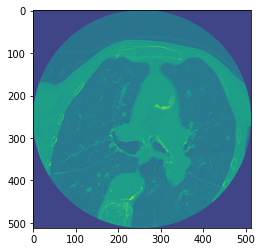

In [7]:
import matplotlib.pyplot as plt
for images, labels in dataset.take(1):  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    
    plt.imshow(np.squeeze(numpy_images, axis = 0))
    plt.show()